In [1]:
import re 
import string 
import pandas as pd 
from collections import defaultdict
import spacy 
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from nltk.corpus import stopwords 
STOPWORDS = set(stopwords.words('english'))
from gensim.models import Word2Vec

%matplotlib inline

In [2]:
df = pd.read_csv('bbc-text.csv')
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [4]:
def clean_text(text):
    '''Making the text in lowercase, removing the punctuation,
    square brackets, and words containing numbers'''
    
    text = text.lower()
    text = re.sub(r'\[.*?\]','' , text)
    text = re.sub(r'[%s]' %re.escape(string.punctuation) , '' , text)
    text = re.sub(r'\w*\d\w*', '' , text)
    
    #Removing the sentence if it's only one word long
    if len(text) >2:
        return ' '.join(word for word in text.split() if word not in STOPWORDS)
    

df_clean = pd.DataFrame(df.text.apply(lambda x : clean_text(x)))

In [5]:
df_clean.head()

,text
0,tv future hands viewers home theatre systems p...
1,worldcom boss left books alone former worldcom...
2,tigers wary farrell gamble leicester say rushe...
3,yeading face newcastle fa cup premiership side...
4,ocean twelve raids box office ocean twelve cri...


In [6]:
nlp = spacy.load('en_core_web_sm', disable = ['ner' ,'parser']) #disabling Name entity recognition for better speed 

def lemmatizer(text):
    sent = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
    return ' '.join(sent)

df_clean['text_lemmatize'] = df_clean.apply(lambda x : lemmatizer(x['text']), axis = 1)

df_clean['text_lemmatize_clean'] = df_clean['text_lemmatize'].str.replace('-PRON-','')

Now we can look up at 10 most frequent word

In [7]:
sentences = [row.split() for row in df_clean['text_lemmatize_clean']]
word_freq = defaultdict(int)

for sent in sentences:
    for i in sent:
        word_freq[i] += 1
        
sorted(word_freq , key = word_freq.get, reverse = True)[:10]

['say', 'mr', 'year', 'would', 'make', 'also', 'people', 'new', 'one', 'take']

Implementing Word2Vec using gensim

In [8]:
w2v_model = Word2Vec(min_count = 200,
        window = 5,
        size = 100,
        workers = 4)

w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count , epochs= w2v_model.iter)
w2v_model.init_sims(replace = True)

<ipython-input-8-b23c0e73989c>:7: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  w2v_model.train(sentences, total_examples=w2v_model.corpus_count , epochs= w2v_model.iter)


Exploring the model

In [9]:
w2v_model.wv.most_similar(positive=['economy'])

[('economic', 0.9890088438987732),
 ('rate', 0.9344823360443115),
 ('continue', 0.9323926568031311),
 ('growth', 0.9281355142593384),
 ('interest', 0.9039503335952759),
 ('low', 0.885406494140625),
 ('demand', 0.8494743704795837),
 ('figure', 0.8459094166755676),
 ('job', 0.8453096151351929),
 ('strong', 0.844545841217041)]

In [10]:
w2v_model.wv.most_similar(positive=['president'])

[('commission', 0.955967366695404),
 ('financial', 0.9469355940818787),
 ('state', 0.9098255038261414),
 ('trade', 0.8993997573852539),
 ('foreign', 0.8973238468170166),
 ('fund', 0.8960174322128296),
 ('investment', 0.8945125341415405),
 ('raise', 0.8664529323577881),
 ('agree', 0.848688006401062),
 ('house', 0.8397629261016846)]

In [11]:
w2v_model.wv.similarity('company','business')

0.86361307

<ipython-input-12-4f15bcb35a67>:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  tokens.append(model[word])


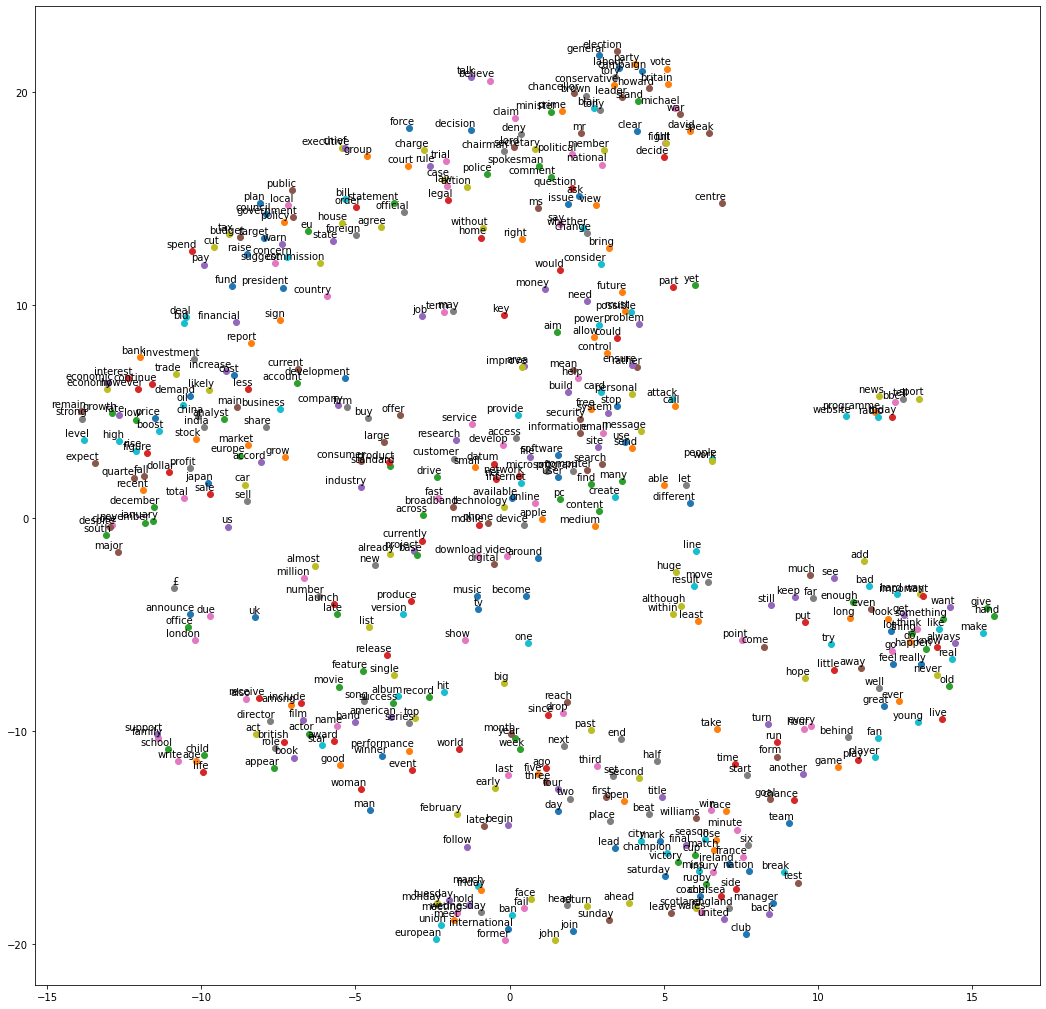

In [12]:
def tsne_plot(model):
    '''Creating a TSNE model and plotting it'''
    
    labels = []
    tokens = []
    
    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
        
    tsne_model = TSNE(perplexity= 40 , n_components = 2 , init ='pca', n_iter=2500 , random_state=23)
    new_values = tsne_model.fit_transform(tokens)
    
    x = []
    y = []
    
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
        
    plt.figure(figsize = (18,18))
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                    xy = (x[i] ,y [i]),
                    xytext = (5,2),
                    textcoords = 'offset points',
                    ha = 'right',
                    va = 'bottom')
        
    plt.show()
        
tsne_plot(w2v_model)